In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import svm
from sklearn.preprocessing import normalize, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score
from sklearn.cluster import KMeans
from kmodes.kprototypes import KPrototypes

In [33]:
data = pd.read_csv('https://raw.githubusercontent.com/askidelsky/DAV-6150/main/Data%20Sets/Project%202/Project2_Data.csv')
labels = pd.read_csv('https://raw.githubusercontent.com/askidelsky/DAV-6150/main/Data%20Sets/Project%202/Project2_Data_Labels.csv')

## **2) Pre-Clustering EDA:** 

Data Description:

"Administrative", "Administrative Duration", "Informational", "Informational Duration", "Product Related", and "Product Related Duration" are the number of different types of pages visited by the visitor in that session and total time spent in each of these categories.

"Bounce Rate", "Exit Rate", and "Page Value" represent metrics for each page in the e-commerce site. The bounce rate is the percentage of users who enter the site from that page and leave without triggering other requests. Exit rate is calculated as for all pageviews to the page, the percentage that were the last in the session. Page value represents the average value of a page that a user visited before completing an e-commerce transaction. Special day feature indicates the closeness of the site visiting time to a specific day in which the sessions are more likely to be finalized with the transaction. 


1. Administrative: the number of administrative pages visited by the visitor in that session
2. Administrative_Duration: total time spent on the administrative page
3. Informational: the number of informational pages visited by the visitor in that session
4. Informational_Duration: total time spent on an informational page
5. ProductRelated: the number of product-related pages visited by the visitor in that session
6. ProductRelated_Duration: total time spent on product-related page
7. BounceRates: the percentage of visitors who enter the site from that page and then leave ("bounce") without triggering any other requests to the analytics server during that session.
8. ExitRates: the value of the "Exit Rate" feature for a specific web page is calculated as for all pageviews to the page, the percentage that was the last in the session.
9. PageValues: the "Page Value" feature represents the average value for a web page that a user visited before completing an e-commerce transaction.
10. SpecialDay: the closeness of the site visiting time to a specific special day (e.g. Mother’s Day, Valentine's Day) in which the sessions are more likely to be finalized with the transaction.
11. Month: month of the year.
12. OperatingSystems: different operating systems of the machine used by the user to access the website
13. Browser: different browsers used by the user to access the website
14. Region: the region of the user visiting the site
15. TrafficType: different vehicles used by users
16. VisitorType: returning/new visitor
17. Weekend: a Boolean value indicating whether the date of the visit is weekend.


In [ ]:
data.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend
0,0,0.0,0,0.0,8,222.000000,0.000000,0.028571,53.474571,0.0,May,1,1,1,2,New_Visitor,True
1,0,0.0,0,0.0,14,1037.500000,0.014286,0.047619,0.000000,0.0,Mar,2,2,4,2,Returning_Visitor,False
2,4,37.5,2,82.0,4,96.625000,0.000000,0.017500,0.000000,0.0,Nov,2,2,9,2,New_Visitor,False
3,4,115.7,0,0.0,16,655.383333,0.000000,0.012037,0.000000,0.0,Nov,1,1,2,3,Returning_Visitor,False
4,1,60.0,1,15.0,26,670.166667,0.000000,0.003846,0.000000,0.0,May,2,2,3,4,Returning_Visitor,False


In [ ]:
data.dtypes

Administrative               int64
Administrative_Duration    float64
Informational                int64
Informational_Duration     float64
ProductRelated               int64
ProductRelated_Duration    float64
BounceRates                float64
ExitRates                  float64
PageValues                 float64
SpecialDay                 float64
Month                       object
OperatingSystems             int64
Browser                      int64
Region                       int64
TrafficType                  int64
VisitorType                 object
Weekend                       bool
dtype: object

Not all numeric values are truely numeric, browser, region, traffic type, visitor type are all identifiers.

In [ ]:
  data.isna().sum().sum()

0

No missing values in data set, we can move on with EDA.

2) Pre-Clustering Exploratory Data Analysis (10 Points)

Data needs to be standardized and scaled before going into a lot of clustering algorithms so the data will have to be put through a standard scaler. All of the variables are extremely right skewed and as such need to be put through a distribution transformation. Even ExitRates, which has a more variable distribution is skewed but less so.

Before going into a clustering algorithm, it needs to be treated for outliers. According to the above distribution charts, there don't seem to be very many outliers for the numeric values so we shouldn't be too worried about those impacting our analysis, especially after transformation.

Based on looking at the data, we can tell that Month, OperatingSystems, Browser, Region, TrafficType, VisitorType, and weekend are all categorical with no inherent ranking which means that we will have to remove them since clustering algorithms don't well with non-numeric data.

3) Pre-Clustering Data Preparation (5 Points):

As stated before, all numerical values will need to be standardized to use in a clustering algorithm so that no variable will be treated with greater weight than the others.

In [116]:
cats = data.iloc[:,[10,11,12,13,14,15,16]]
numerical = data.drop(columns=cats.columns)
cats = cats.astype('string')
cats = pd.get_dummies(cats)
numerical = numerical.astype('float')
data_converted = pd.concat([cats, numerical], axis=1)
std_numerical_xtra_cols = (numerical - numerical.mean())/numerical.std()
std_numerical_xtra_cols.columns

Index(['Administrative', 'Administrative_Duration', 'Informational',
       'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration',
       'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay'],
      dtype='object')

In [117]:
std_numerical = std_numerical_xtra_cols[std_numerical_xtra_cols.columns[:10]]
std_numerical.columns

Index(['Administrative', 'Administrative_Duration', 'Informational',
       'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration',
       'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay'],
      dtype='object')

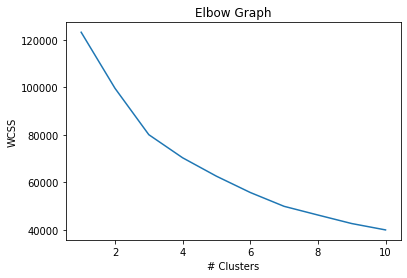

In [111]:
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(std_numerical)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('Elbow Graph')
plt.xlabel('# Clusters')
plt.ylabel('WCSS')
plt.show()

In [112]:
kmeans = KMeans(n_clusters = 2, init = 'k-means++', random_state = 42)
y_kmeans = kmeans.fit_predict(std_numerical)
len([pred for pred in y_kmeans if pred])/len(y_kmeans)

0.1523925385239254

In [113]:
y_kmeans

array([0, 0, 0, ..., 0, 0, 0])

In [114]:
X = std_numerical
X[y_kmeans] = y_kmeans
plt.scatter(X[y_kmeans == 0, 0], X[y_kmeans == 0, 1], s = 100, c = 'red', label = 'Cluster 1')
plt.scatter(X[y_kmeans == 1, 0], X[y_kmeans == 1, 1], s = 100, c = 'blue', label = 'Cluster 2')
# plt.scatter(X[y_kmeans == 2, 0], X[y_kmeans == 2, 1], s = 100, c = 'green', label = 'Cluster 3')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s = 300, c = 'yellow', label = 'Centroids')
plt.title('Clusters of observations')
plt.xlabel('')
plt.ylabel('')
plt.legend()
plt.show()

KeyboardInterrupt: 

In [ ]:
kproto = KPrototypes(n_clusters=2, verbose=1, max_iter=5)

Initialization method and algorithm are deterministic. Setting n_init to 1.


In [ ]:
cat_idx = [10,11,12,13,14,15,16]
kproto.fit(data, categorical=cat_idx)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/20, moves: 3215, ncost: 25269720739.398853
Run: 1, iteration: 2/20, moves: 1264, ncost: 22779258011.523422
Run: 1, iteration: 3/20, moves: 550, ncost: 21883804403.604412
Run: 1, iteration: 4/20, moves: 227, ncost: 21638570354.814934
Run: 1, iteration: 5/20, moves: 98, ncost: 21586230503.80413
Run: 1, iteration: 6/20, moves: 57, ncost: 21568598046.816093
Run: 1, iteration: 7/20, moves: 16, ncost: 21565873046.853485
Run: 1, iteration: 8/20, moves: 20, ncost: 21563467654.16907
Run: 1, iteration: 9/20, moves: 7, ncost: 21563116011.262054
Run: 1, iteration: 10/20, moves: 3, ncost: 21563019027.35191
Run: 1, iteration: 11/20, moves: 3, ncost: 21562938840.20266
Run: 1, iteration: 12/20, moves: 2, ncost: 21562880461.71018
Run: 1, iteration: 13/20, moves: 2, ncost: 21562841261.886047
Run: 1, iteration: 14/20, moves: 1, ncost: 21562830347.361187
Run: 1, iteration: 15/20, moves: 1, ncost: 215628220

KPrototypes(gamma=352.45561184467806, max_iter=20, n_clusters=2, verbose=2)

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay
0,-0.696965,-0.457173,-0.396462,-0.244921,-0.533585,-0.508315,-0.457664,-0.298403,2.562699,-0.308809
1,-0.696965,-0.457173,-0.396462,-0.244921,-0.398679,-0.082170,-0.163043,0.093551,-0.317165,-0.308809
2,0.507207,-0.245044,1.178147,0.337676,-0.623522,-0.573830,-0.457664,-0.526227,-0.317165,-0.308809
3,0.507207,0.197316,-0.396462,-0.244921,-0.353711,-0.281847,-0.457664,-0.638641,-0.317165,-0.308809
4,-0.395922,-0.117766,0.390843,-0.138348,-0.128868,-0.274122,-0.457664,-0.807190,-0.317165,-0.308809
...,...,...,...,...,...,...,...,...,...,...
12325,0.206164,0.380030,-0.396462,-0.244921,-0.533585,-0.471474,-0.457664,-0.325127,-0.317165,-0.308809
12326,-0.395922,-0.406262,0.390843,-0.035328,-0.196321,-0.019420,-0.299022,0.221690,-0.317165,-0.308809
12327,-0.696965,-0.457173,-0.396462,-0.244921,1.332611,1.548275,-0.251429,-0.309885,-0.317165,-0.308809
12328,-0.696965,-0.457173,-0.396462,-0.244921,0.140943,0.116488,-0.125271,0.116164,-0.317165,4.718407


In [15]:
kmeans = KMeans(n_clusters=2, random_state=0).fit(std_numerical)

In [ ]:
import scipy.cluster.hierarchy as sch
dendrogram = sch.dendrogram(sch.linkage(std_numerical, method = 'ward'))

In [ ]:
plt.title('Dendrogram')
plt.xlabel('User Visit Observation')
plt.ylabel('Euclidean distances')
plt.show()

In [ ]:
for i, col in enumerate(data_converted.columns):
  print(i, " ", col)

0   Month
1   OperatingSystems
2   Browser
3   Region
4   TrafficType
5   VisitorType
6   Weekend
7   Administrative
8   Administrative_Duration
9   Informational
10   Informational_Duration
11   ProductRelated
12   ProductRelated_Duration
13   BounceRates
14   ExitRates
15   PageValues
16   SpecialDay


In [ ]:
[data.columns[i] for i in [10,11,12,13,14,15,16]]

['Month',
 'OperatingSystems',
 'Browser',
 'Region',
 'TrafficType',
 'VisitorType',
 'Weekend']

In [ ]:
[data.columns[i] for i in [10,11,12,13,14,15,16]]

['Month',
 'OperatingSystems',
 'Browser',
 'Region',
 'TrafficType',
 'VisitorType',
 'Weekend']

In [14]:
std = StandardScaler().fit_transform(numerical)
std

array([[-0.69699296, -0.4571914 , -0.3964779 , ..., -0.29841542,
         2.56280291, -0.30882137],
       [-0.69699296, -0.4571914 , -0.3964779 , ...,  0.0935547 ,
        -0.31717784, -0.30882137],
       [ 0.50722805, -0.24505366,  1.17819516, ..., -0.52624805,
        -0.31717784, -0.30882137],
       ...,
       [-0.69699296, -0.4571914 , -0.3964779 , ..., -0.30989738,
        -0.31717784, -0.30882137],
       [-0.69699296, -0.4571914 , -0.3964779 , ...,  0.11616835,
        -0.31717784,  4.71859801],
       [-0.39593771, -0.03998718, -0.3964779 , ..., -0.47193431,
        -0.31717784, -0.30882137]])

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay
0,-0.696965,-0.457173,-0.396462,-0.244921,-0.533585,-0.508315,-0.457664,-0.298403,2.562699,-0.308809
1,-0.696965,-0.457173,-0.396462,-0.244921,-0.398679,-0.082170,-0.163043,0.093551,-0.317165,-0.308809
2,0.507207,-0.245044,1.178147,0.337676,-0.623522,-0.573830,-0.457664,-0.526227,-0.317165,-0.308809
3,0.507207,0.197316,-0.396462,-0.244921,-0.353711,-0.281847,-0.457664,-0.638641,-0.317165,-0.308809
4,-0.395922,-0.117766,0.390843,-0.138348,-0.128868,-0.274122,-0.457664,-0.807190,-0.317165,-0.308809
...,...,...,...,...,...,...,...,...,...,...
12325,0.206164,0.380030,-0.396462,-0.244921,-0.533585,-0.471474,-0.457664,-0.325127,-0.317165,-0.308809
12326,-0.395922,-0.406262,0.390843,-0.035328,-0.196321,-0.019420,-0.299022,0.221690,-0.317165,-0.308809
12327,-0.696965,-0.457173,-0.396462,-0.244921,1.332611,1.548275,-0.251429,-0.309885,-0.317165,-0.308809
12328,-0.696965,-0.457173,-0.396462,-0.244921,0.140943,0.116488,-0.125271,0.116164,-0.317165,4.718407
